# Demo of SF error analysis
### Semi-empirical approach to computing second-order statistics of gapped series

Statistical moments of increments. 
$$D_p(\tau)=\langle | x(t+\tau)-x(t))^p | \rangle$$

**Outputs (plots):**
1. Bad and interpolated SF example
2. CH estimator example
3. Bad and LINT: MPE as fn of lag, coloured by % missing overall (multi-line plot)
3. Bad and LINT: Heatmaps of MPE as fn of lag and % missing
4. LINT: Empirically-corrected SFs
5. LINT: Hybrid correction

**Next steps: (commit as you go)**

2. Add C-H estimator
3. Add this to final plot of corrections at the end (as well as an initial correction)
4. Work on inputs: more, standardised lengths
5. Confirm Rāpoi params
6. Convert to Rāpoi script
7. Run on Rāpoi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sf_funcs import (
    compute_sf,
    plot_sample,
    plot_error_trend_line,
    plot_error_trend_scatter,
    plot_heatmap,
    compute_scaling,
)
import ts_dashboard_utils as ts

plt.rcParams.update({"font.size": 10})

Below taken directly from reynolds utils script

In [2]:
def compute_nd_acf(time_series, nlags, plot=False):
    """Compute the autocorrelation function for a scalar or vector time series.

    Args:

    - time_series: list of 1 (scalar) or 3 (vector) pd.Series. The function automatically detects
    the cadence if timestamped index, otherwise dt = 1s.
    - nlags: The number of lags to calculate the ACF up to
    - plot: Whether to plot the ACF

    Returns:

    - time_lags: The x-values of the ACF, in seconds, given the cadence of measurements
    - R: The values of the ACF from lag 0 to nlags

    """

    # Convert the time series into a numpy array
    np_array = np.array(time_series)

    if np_array.shape[0] == 3:
        acf = (
            # missing="conservative" ignores NaNs when computing the ACF
            sm.tsa.acf(np_array[0], fft=True, nlags=nlags, missing="conservative")
            + sm.tsa.acf(np_array[1], fft=True, nlags=nlags, missing="conservative")
            + sm.tsa.acf(np_array[2], fft=True, nlags=nlags, missing="conservative")
        )
        acf /= 3

    elif np_array.shape[0] == 1:
        acf = sm.tsa.acf(np_array[0], fft=True, nlags=nlags)

    else:
        raise ValueError(
            "Array is not 3D or 1D. If after a 1D acf, try putting square brackets around the pandas series in np.array()"
        )

    # Check if the data has a timestamp index
    if isinstance(time_series[0].index, pd.DatetimeIndex):
        # Get the cadence of the data
        dt = time_series[0].index[1] - time_series[0].index[0]
        dt = dt.total_seconds()
    else:
        # If not, assume 1 second cadence
        dt = 1

    time_lags = np.arange(0, nlags + 1) * dt

    # Optional plotting
    if plot is True:
        fig, ax = plt.subplots(constrained_layout=True)

        ax.plot(time_lags, acf)
        ax.set_xlabel("$\\tau$ (sec)")
        ax.set_ylabel("Autocorrelation")

        # For plotting secondary axes
        def sec2lag(x):
            return x / dt

        def lag2sec(x):
            return x * dt

        secax_x = ax.secondary_xaxis("top", functions=(sec2lag, lag2sec))
        secax_x.set_xlabel("$\\tau$ (lag)")

        def sec2km(x):
            return x * 400

        def km2sec(x):
            return x / 400

        # use of a float for the position:
        secax_x2 = ax.secondary_xaxis(-0.2, functions=(sec2km, km2sec))
        secax_x2.set_xlabel("$r$ (km)")

        plt.show()

    return time_lags, acf


In [3]:
def compute_outer_scale_exp_trick(
    autocorrelation_x: np.ndarray, autocorrelation_y: np.ndarray, plot=False
):
    """
    computes the correlation scale through the "1/e" estimation method.
    autocorrelation_x assumed already in time scale
    """
    for i, j in zip(autocorrelation_y, autocorrelation_x):
        if i <= np.exp(-1):
            # print(i, j)
            idx_2 = np.where(autocorrelation_x == j)[0]
            idx_1 = idx_2 - 1
            x2 = autocorrelation_x[idx_2]
            x1 = autocorrelation_x[idx_1]
            y1 = autocorrelation_y[idx_1]
            y2 = autocorrelation_y[idx_2]
            x_opt = x1 + ((y1 - np.exp(-1)) / (y1 - y2)) * (x2 - x1)
            # print(autocorrelation_x[idx_1], autocorrelation_y[idx_1])
            # print(autocorrelation_x[idx_2], autocorrelation_y[idx_2])
            # print('e:', np.exp(-1))
            # print(x_opt)

            try:
                # Optional plotting, set up to eventually display all 3 corr scale methods
                if plot is True:
                    fig, ax = plt.subplots(
                        1, 1, figsize=(3.3, 2.5), constrained_layout=True
                    )
                    # fig.subplots_adjust(left=0.2, top=0.8, bottom=0.8)

                    ax.plot(
                        autocorrelation_x / 1000,
                        autocorrelation_y,
                        c="black",
                        label="Autocorrelation",
                        lw=0.5,
                    )
                    ax.set_xlabel("$\\tau (10^3$ s)")
                    ax.set_ylabel("$R(\\tau)$")

                    def sec2km(x):
                        return x * 1000 * 400 / 1e6

                    def km2sec(x):
                        return x / 1000 / 400 * 1e6

                    # use of a float for the position:
                    secax_x2 = ax.secondary_xaxis("top", functions=(sec2km, km2sec))
                    secax_x2.set_xlabel("$r$ ($10^6$ km)")
                    secax_x2.tick_params(which="both", direction="in")
                    ax.axhline(
                        np.exp(-1),
                        color="black",
                        ls="--",
                        label="$1/e\\rightarrow\\lambda_C^{{1/e}}$={:.0f}s".format(
                            x_opt[0]
                        ),
                    )
                    ax.axvline(x_opt[0] / 1000, color="black", ls="--")
                    ax.tick_params(which="both", direction="in")
                    # label="$1/e\\rightarrow \lambda_C^{1/e}=${:.0f}s".format(x_opt[0]))
                    return round(x_opt[0], 3), fig, ax
                else:
                    return round(x_opt[0], 3)
            except Exception:
                return 0

    # none found
    return -1


In [4]:
def normalize(data):
    # Remove any NA values to calculate mean and std, but leave them in the output set
    clean_data = data[~np.isnan(data)]
    mean = np.mean(clean_data)
    std = clean_data.std()
    result = (data - mean) / std
    return result


## Load in the data
A magnetic field time series from PSP

In [5]:
df_raw_full = pd.read_pickle("data/processed/psp/psp_fld_l2_mag_rtn_201811.pkl")
df_raw = df_raw_full["B_R"]
df_raw.head()


Time
2018-11-02 00:01:09.195182976   -11.061315
2018-11-02 00:01:09.208836480   -10.854164
2018-11-02 00:01:09.222489856   -11.197883
2018-11-02 00:01:09.236143104   -11.008248
2018-11-02 00:01:09.249796352   -11.188342
Name: B_R, dtype: float64

Optionally, check the data for missing data and its frequency, get summary stats

In [6]:
### 0PTIONAL CODE ###

if df_raw.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{df_raw.isnull().sum()} missing points")
print("Length of interval: " + str(df_raw.notnull().sum()))
print("Duration of interval: " + str(df_raw.index[-1] - df_raw.index[0]))
x = df_raw.values

# Frequency of measurements
print("Duration between some adjacent data points:")
print(df_raw.index[2] - df_raw.index[1])
print(df_raw.index[3] - df_raw.index[2])
print(df_raw.index[4] - df_raw.index[3])

a = df_raw.index[2] - df_raw.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.2f} Hz (2dp)".format(x_freq))

print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}".format(np.std(x)))

### 0PTIONAL CODE END ###


510 missing points
Length of interval: 7522952
Duration of interval: 0 days 17:59:59.987519872
Duration between some adjacent data points:
0 days 00:00:00.013653376
0 days 00:00:00.013653248
0 days 00:00:00.013653248

Frequency is 73.24 Hz (2dp)
Mean = nan
Standard deviation = nan


In [11]:
# Original freq is 0.007s. Resampling to less rapid but still sufficiently high cadence, then splitting into chunks with ~15 correlation times

tce_approx = 500  # s
tce_approx_n = 15
cadence_approx = 0.1  # s

tce_n = 8  # Number of correlation times we want...
interval_length = 4000  # ...across this many points
good_inputs_list = []

df = df_raw.resample(str(cadence_approx) + "S").mean()
interval_length_approx = int(tce_approx * tce_approx_n / cadence_approx)

# We have approximately 10 correlation times in 10,000 points. Let's now be more precise, and calculate the correlation time from each chunk

# Split df into subsets
interval_list_approx = [
    df[i : i + interval_length_approx]
    for i in range(0, len(df) - interval_length_approx + 1, int(interval_length_approx))
]

del df  # free up memory

for interval_approx in interval_list_approx:
    time_lags_lr, r_vec_lr = compute_nd_acf(
        [interval_approx],
        nlags=10000,
        plot=False,
    )

    tce = compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

    if tce == -1:
        tce = 500
        new_cadence = tce_n * tce / interval_length
        print(
            f"tce not found for this chunk, setting to 500s (default) -> cadence = {new_cadence}s"
        )

    else:
        new_cadence = tce_n * tce / interval_length
        print(
            f"tce calculated to be {np.round(tce,2)}s -> cadence = {np.round(new_cadence,2)}s (for {tce_n}tce across {interval_length} points)"
        )

    interval_approx_resampled = interval_approx.resample(
        str(new_cadence) + "S"
    ).mean()  # Resample to higher frequency

    for i in range(
        0, len(interval_approx_resampled) - interval_length + 1, interval_length
    ):
        interval = interval_approx_resampled.iloc[i : i + interval_length]
        int_norm = normalize(interval)
        good_inputs_list.append(int_norm)

print(
    "\nNumber of standardised intervals: "
    + str(len(good_inputs_list))
    + "\n(may be more than one per original chunk for small cadences)"
)


tce calculated to be 472.44s -> cadence = 0.94s (for 8tce across 4000 points)
tce calculated to be 519.81s -> cadence = 1.04s (for 8tce across 4000 points)
tce calculated to be 724.28s -> cadence = 1.45s (for 8tce across 4000 points)
tce calculated to be 612.58s -> cadence = 1.23s (for 8tce across 4000 points)
tce not found for this chunk, setting to 500s (default) -> cadence = 1.0s
tce calculated to be 181.96s -> cadence = 0.36s (for 8tce across 4000 points)
tce calculated to be 860.62s -> cadence = 1.72s (for 8tce across 4000 points)
tce not found for this chunk, setting to 500s (default) -> cadence = 1.0s

Number of standardised intervals: 12
(may be more than one per original chunk for small cadences)


[[<matplotlib.lines.Line2D at 0x16dc3d3dd80>],

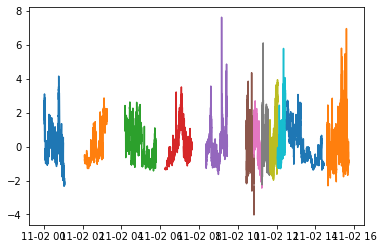

In [12]:
[plt.plot(interval) for interval in good_inputs_list]

## Remove data from each input multiple times and compute SF, naive and interpolated

**Run this on Rāpoi:** currently it takes ~0.5s per 1000 length interval (up to lag 250)

In [13]:
# Logarithmically-spaced lags?
# vals = np.logspace(0, 3, 0.25 * len(good_inputs_list[0]))
# lags = np.unique(vals.astype(int))
lags = np.arange(1, 0.25 * len(good_inputs_list[0]))
powers = [2]
times_to_gap = 2

good_outputs_list = []
all_bad_inputs_list = []
all_bad_outputs_list = []
all_interp_inputs_list = []
all_interp_outputs_list = []

for i, input in enumerate(good_inputs_list):
    print("\nProcessing input {}".format(i))
    good_output = compute_sf(pd.DataFrame(input), lags, powers)
    good_outputs_list.append(good_output)

    bad_inputs_list = []
    bad_outputs_list = []
    interp_inputs_list = []
    interp_outputs_list = []

    for total_removal in np.random.uniform(0, 0.9, times_to_gap):
        # Remove data (up to about 90%, may be some numerical issues with large %)
        # in both chunks and uniformly - split given by ratio_removal
        ratio_removal = np.random.uniform()
        print("Nominal total removal: {0:.1f}%".format(total_removal * 100))
        print("Nominal ratio: {0:.1f}%".format(ratio_removal * 100))
        prop_remove_chunks = total_removal * ratio_removal
        prop_remove_unif = total_removal * (1 - ratio_removal)
        bad_input_temp, bad_input_ind, prop_removed = ts.remove_data(
            input, prop_remove_chunks, chunks=5
        )
        bad_input, bad_input_ind, prop_removed = ts.remove_data(
            bad_input_temp, prop_remove_unif
        )

        print(
            "Removed {0:.1f}% (approx. {1:.1f}% in chunks, {2:.1f}% uniformly)".format(
                prop_removed * 100, prop_remove_chunks * 100, prop_remove_unif * 100
            )
        )

        bad_inputs_list.append(bad_input)

        # Linearly interpolate the missing data
        interp_input = bad_input.interpolate(method="linear")
        interp_inputs_list.append(interp_input)

        bad_output = compute_sf(pd.DataFrame(bad_input), lags, powers)
        bad_output["error"] = bad_output["sosf"] - good_output["sosf"]
        bad_output["error_percent"] = bad_output["error"] / good_output["sosf"] * 100
        bad_output["missing_prop_overall"] = prop_removed
        bad_output["lint"] = False
        bad_outputs_list.append(bad_output)

        interp_output = compute_sf(pd.DataFrame(interp_input), lags, powers)
        interp_output["error"] = interp_output["sosf"] - good_output["sosf"]
        interp_output["error_percent"] = (
            interp_output["error"] / good_output["sosf"] * 100
        )
        interp_output["missing_prop_overall"] = prop_removed
        interp_output["missing_prop"] = bad_output["missing_prop"]
        interp_output["missing_prop"] = bad_output["missing_prop"]
        interp_output["sosf_se"] = bad_output["sosf_se"]
        # NOTE: Seems sensible uncertainty is the same for both
        interp_output["lint"] = True
        interp_outputs_list.append(interp_output)

    all_bad_inputs_list.append(bad_inputs_list)
    all_bad_outputs_list.append(bad_outputs_list)
    all_interp_inputs_list.append(interp_inputs_list)
    all_interp_outputs_list.append(interp_outputs_list)


Processing input 0
Nominal total removal: 8.4%
Nominal ratio: 66.1%
Removed 8.9% (approx. 5.5% in chunks, 2.8% uniformly)
Nominal total removal: 19.6%
Nominal ratio: 42.1%
Removed 18.6% (approx. 8.2% in chunks, 11.4% uniformly)

Processing input 1
Nominal total removal: 76.2%
Nominal ratio: 85.9%
Removed 75.5% (approx. 65.5% in chunks, 10.7% uniformly)
Nominal total removal: 53.9%
Nominal ratio: 65.9%
Removed 49.1% (approx. 35.5% in chunks, 18.4% uniformly)

Processing input 2
Nominal total removal: 81.7%
Nominal ratio: 53.7%
Removed 65.2% (approx. 43.9% in chunks, 37.8% uniformly)
Nominal total removal: 46.5%
Nominal ratio: 59.5%
Removed 41.5% (approx. 27.7% in chunks, 18.8% uniformly)

Processing input 3
Nominal total removal: 71.9%
Nominal ratio: 70.5%
Removed 66.5% (approx. 50.7% in chunks, 21.2% uniformly)
Nominal total removal: 59.7%
Nominal ratio: 69.4%
Removed 53.3% (approx. 41.4% in chunks, 18.3% uniformly)

Processing input 4
Nominal total removal: 0.9%
Nominal ratio: 8.9%
R

## Check a sample of results, for a given source interval

### Naive

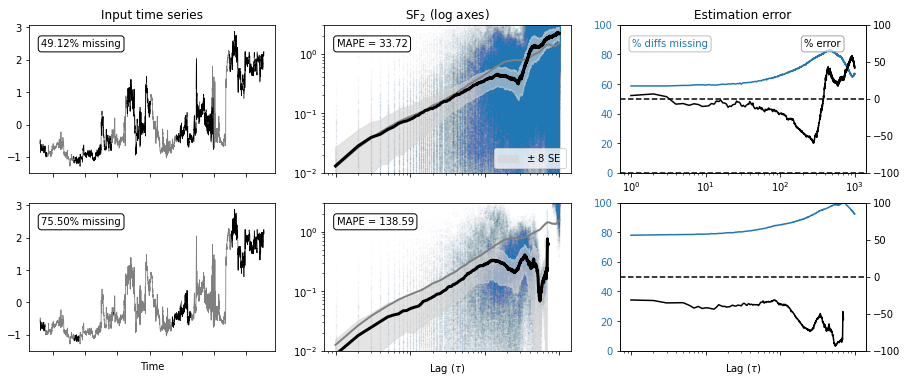

In [14]:
# Check results, for a given clean input

input_ind = 1
n = 2

plot_sample(
    good_inputs_list,
    good_outputs_list,
    all_bad_inputs_list,
    all_bad_outputs_list,
    "C0",
    input_ind,
    n,
    False,
)

### Interpolated
NB: Error region for these results are taken from the SE for the naive calculations, relecting the increased uncertainty of fewer *true* observations

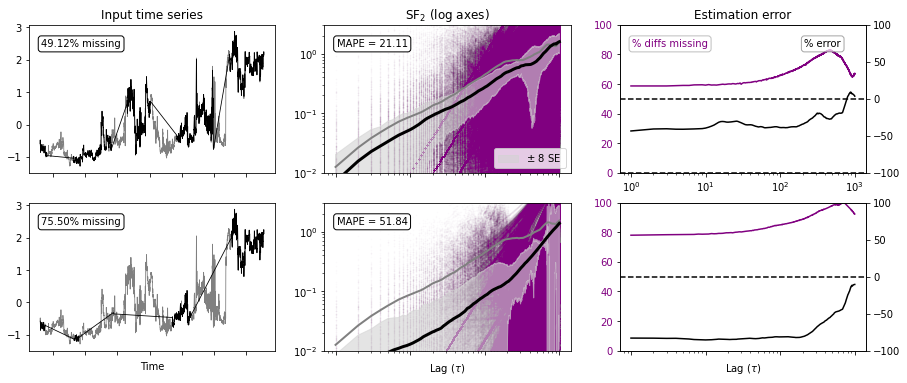

In [15]:
plot_sample(
    good_inputs_list,
    good_outputs_list,
    all_interp_inputs_list,
    all_interp_outputs_list,
    "purple",
    input_ind,
    2,
    False,
)

## Do holistic analysis of errors

In [16]:
# Concatenate the list of lists of dataframes to a single dataframe for error analysis

bad_outputs_df = pd.concat([pd.concat(lst) for lst in all_bad_outputs_list])
interp_outputs_df = pd.concat([pd.concat(lst) for lst in all_interp_outputs_list])

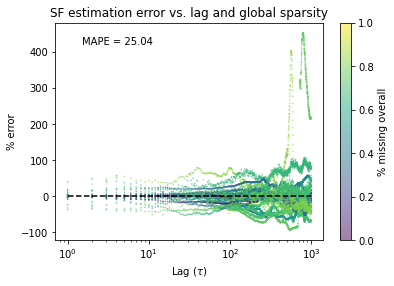

In [17]:
# View trends as fn of OVERALL missing amount
plot_error_trend_line(bad_outputs_df)

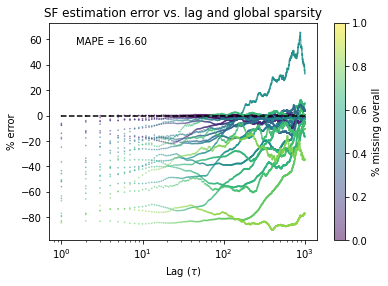

In [18]:
plot_error_trend_line(interp_outputs_df)

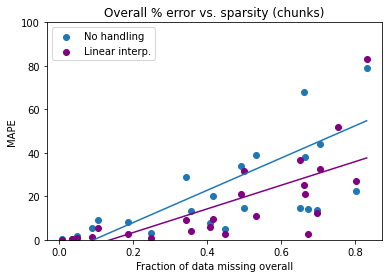

In [19]:
plot_error_trend_scatter(bad_outputs_df, interp_outputs_df)

## Create empirical correction factor

Here we work with the interpolated output errors, as they are more consistent that the no-handling errors (as evident in the error vs. lag and global sparsity plot), and with the *local* sparsity, as this gives us more information than the global sparsity.

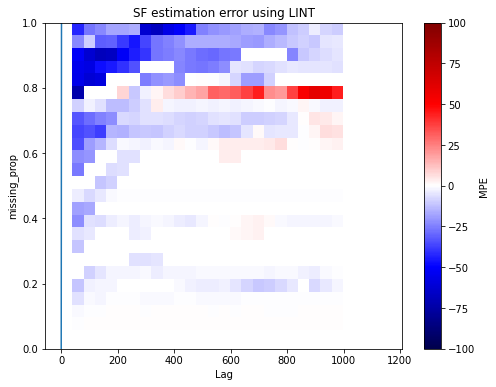

In [20]:
# Compute heatmap of average error as fn of lag and missing prop at that lag
interp_heatmap = plot_heatmap(
    interp_outputs_df, "missing_prop", 25, False, overlay_x, overlay_y
)

## Apply empirical correction factor

No nearest row found for lag 421.0! Scaling set to 1
No nearest row found for lag 422.0! Scaling set to 1
No nearest row found for lag 423.0! Scaling set to 1
No nearest row found for lag 424.0! Scaling set to 1
No nearest row found for lag 425.0! Scaling set to 1
No nearest row found for lag 428.0! Scaling set to 1
No nearest row found for lag 429.0! Scaling set to 1
No nearest row found for lag 431.0! Scaling set to 1
No nearest row found for lag 432.0! Scaling set to 1
No nearest row found for lag 436.0! Scaling set to 1
No nearest row found for lag 441.0! Scaling set to 1
No nearest row found for lag 443.0! Scaling set to 1
No nearest row found for lag 448.0! Scaling set to 1


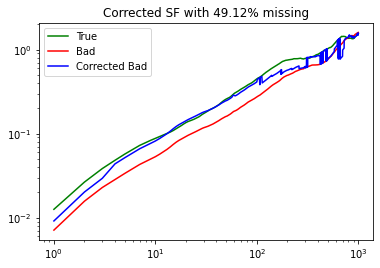

In [21]:
# Compute scaling factors for a given corrupted interval
# (ensure using interp factors for interp interval)
interval = 1
sf_corrected = compute_scaling(
    all_interp_outputs_list[input_ind][interval], "missing_prop", interp_heatmap
)

# Apply the correction and plot the corrected SF
plt.plot(good_outputs_list[input_ind]["sosf"], c="green", label="True")
plt.plot(all_interp_outputs_list[input_ind][interval]["sosf"], c="red", label="Bad")
plt.plot(
    sf_corrected["sosf"] * sf_corrected["scaling"], c="blue", label="Corrected Bad"
)
plt.semilogx()
plt.semilogy()
plt.legend()
plt.title(
    f"Corrected SF with {np.round(sf_corrected['missing_prop_overall'].values[0]*100, 2)}% missing"
)
plt.show()


In [22]:
# Compute scaling factors for a given corrupted interval
# (ensure using interp factors for interp interval)
interval = 4
sf_corrected = compute_scaling(
    all_interp_outputs_list[input_ind][interval], "missing_prop", interp_heatmap
)
# Plot the corrected SF
plt.plot(good_outputs_list[input_ind]["sosf"], c="green", label="True")
plt.plot(all_interp_outputs_list[input_ind][interval]["sosf"], c="red", label="Bad")
plt.plot(
    sf_corrected["sosf"] * sf_corrected["scaling"], c="blue", label="Corrected Bad"
)
plt.semilogx()
plt.semilogy()
plt.legend()
plt.title(
    f"Corrected SF with {np.round(sf_corrected['missing_prop_overall'].values[0]*100, 2)}% missing"
)
plt.show()


IndexError: list index out of range